In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
#file_name = "/content/drive/MyDrive/splitted_new_leaf.zip"
file_name = "/content/drive/MyDrive/Finaru.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import torchvision
import time

%matplotlib inline

In [ ]:
#data_dir = ".\\datasets\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)"
#data_dir = "/content/datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
#data_dir = "/content/PREPROCESS/process"
data_dir = "/content/Finaru"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/val"
#train_dir = data_dir + "\\train"
#valid_dir = data_dir + "\\valid"
diseases = os.listdir(train_dir)

In [ ]:
print(diseases)

['Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Strawberry___Leaf_scorch', 'Grape___Black_rot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___Early_blight', 'Peach___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Squash___Powdery_mildew', 'Potato___Late_blight', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Pepper_bell___Bacterial_spot', 'Tomato___Target_Spot', 'Tomato___Early_blight', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Leaf_Mold']


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
print(NumberOfDiseases)

20


In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Corn_(maize)___Northern_Leaf_Blight                     1829
Tomato___Late_blight                                    1843
Tomato___Bacterial_spot                                 1843
Tomato___Septoria_leaf_spot                             1823
Strawberry___Leaf_scorch                                1875
Grape___Black_rot                                       1856
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)              1822
Tomato___Tomato_Yellow_Leaf_Curl_Virus                  1840
Potato___Early_blight                                   1820
Peach___Bacterial_spot                                  1807
Tomato___Spider_mites Two-spotted_spider_mite           1807
Squash___Powdery_mildew                                 1824
Potato___Late_blight                                    1804
Grape___Esca_(Black_Measles)                            1859
Corn_(maize)___Common_rust_                             1862
Pepper_bell___Bacterial_spot                            1853
Tomato___Target_Spot                                    1824
Tomato___Early_blight                                   1876
Cherry_(including_sour)___Powdery_mildew                1878
Tomato___Leaf_Mold                                      1808

In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 36753 images for training


In [ ]:
# datasets for validation and training
train = ImageFolder(
        train_dir,
        #transform=transforms.ToTensor(),
        transforms.Compose([
          transforms.Resize((550,550)),
          #transforms.RandomResizedCrop((128,128)),  # image size int or tuple
          # Add more transforms here
          transforms.ToTensor(),  # convert to tensor at the end
        ]))
valid = ImageFolder(
        valid_dir,
        #transform=transforms.ToTensor(),
        transforms.Compose([
          transforms.Resize((550,550)),
          #transforms.RandomResizedCrop((128,128)),  # image size int or tuple
          # Add more transforms here
          transforms.ToTensor(),  # convert to tensor at the end
        ]))

In [ ]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 550, 550]) 0


In [ ]:
# total number of classes in train set
len(train.classes)

20

In [ ]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Cherry_(including_sour)___Powdery_mildew(0)


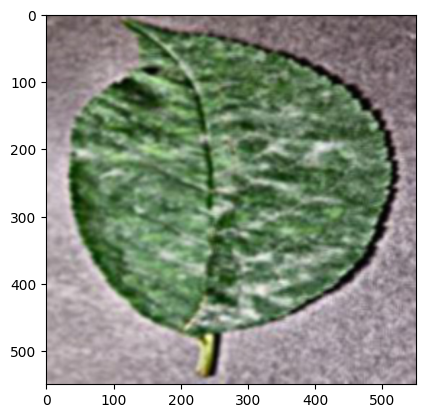

In [ ]:
show_image(*train[0])

Label :Cherry_(including_sour)___Powdery_mildew(0)


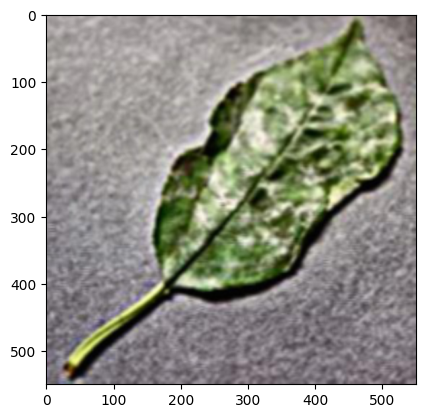

In [ ]:
show_image(*train[100])

Label :Cherry_(including_sour)___Powdery_mildew(0)


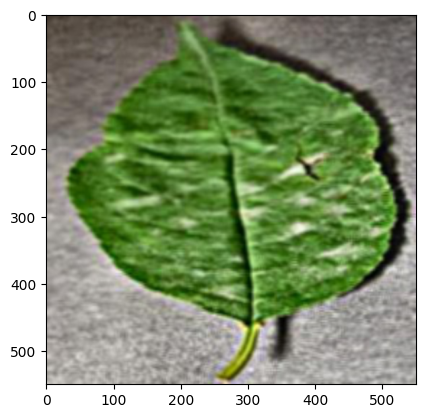

In [ ]:
show_image(*train[50])

In [ ]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
# setting the batch size
batch_size = 32

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True)
valid_dl = DataLoader(valid, batch_size)

In [ ]:
train_dl

In [ ]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

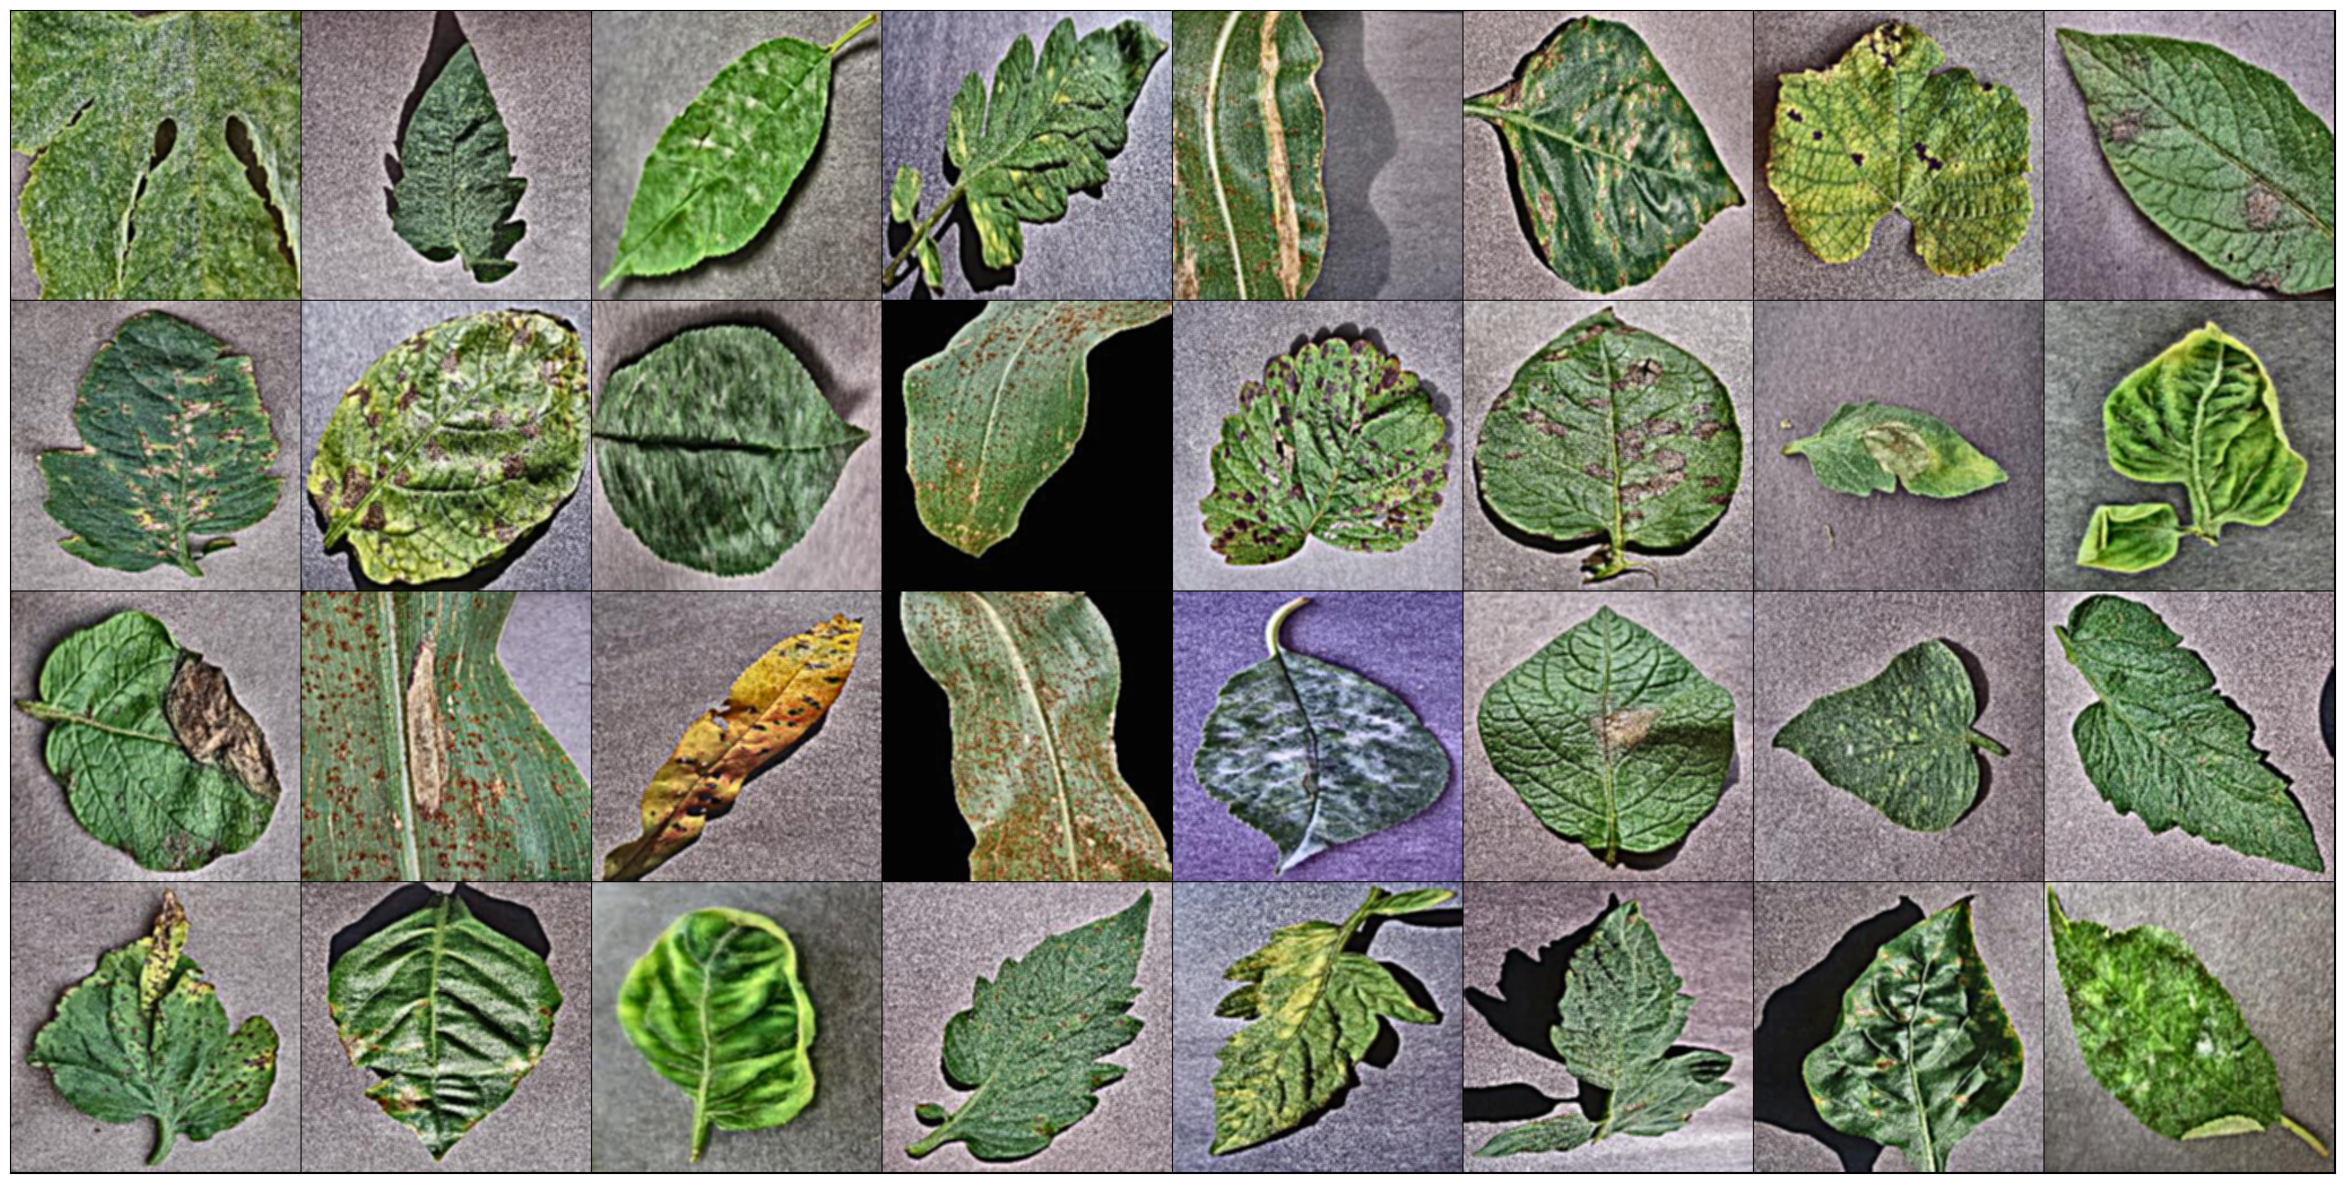

In [ ]:
# Images for first batch of training
show_batch(train_dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc_train = accuracy(out, labels)
        return loss, acc_train

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_accuracy']))

# CNN

In [ ]:
class CNN(ImageClassificationBase):
  def __init__(self, in_channels=3, num_classes=1000):
    super().__init__()
    self.network = nn.Sequential(
      #nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=1),
      #nn.BatchNorm2d(16),
      #nn.ReLU(),
      #nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=1),
      #nn.BatchNorm2d(32),
      #nn.ReLU(),
      #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      #nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(64),
      #nn.ReLU(),
      #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(64),
      #nn.ReLU(),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(128),
      #nn.ReLU(),
      #nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(128),
      #nn.ReLU(),
      #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      #nn.Dropout(0.25)
      #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

      nn.Flatten(),
      nn.Linear(256, 1024),  # Adjusted output size
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 1000)
    )

    #self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8)
    #self.fc = nn.Linear(512, num_classes)

    #self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # same convolution
    #self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    #self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))


  def forward(self, x):
    return self.network(x)

In [ ]:
model = to_device(CNN(), device)

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 50, 50)
print(summary(model, (INPUT_SHAPE))) #.cuda

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             896
       BatchNorm2d-2           [-1, 32, 25, 25]              64
              ReLU-3           [-1, 32, 25, 25]               0
            Conv2d-4           [-1, 64, 13, 13]          18,496
       BatchNorm2d-5           [-1, 64, 13, 13]             128
              ReLU-6           [-1, 64, 13, 13]               0
         MaxPool2d-7             [-1, 64, 6, 6]               0
            Conv2d-8            [-1, 128, 6, 6]          73,856
       BatchNorm2d-9            [-1, 128, 6, 6]             256
             ReLU-10            [-1, 128, 6, 6]               0
           Conv2d-11            [-1, 128, 6, 6]         147,584
      BatchNorm2d-12            [-1, 128, 6, 6]             256
             ReLU-13            [-1, 128, 6, 6]               0
        MaxPool2d-14            [-1, 12

# ViT

In [ ]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.
    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).
    patch_size : int
        Size of the patch (it is a square).
    in_chans : int
        Number of input channels.
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2


        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(
                x
            )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x


class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x


class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x


class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class VisionTransformer(ImageClassificationBase):
    """Simplified implementation of the Vision transformer.
    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).
    patch_size : int
        Both height and the width of the patch (it is a square).
    in_chans : int
        Number of input channels.
    n_classes : int
        Number of classes.
    embed_dim : int
        Dimensionality of the token/patch embeddings.
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.
    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.
    pos_drop : nn.Dropout
        Dropout layer.
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + 289, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)

        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

In [ ]:
custom_config = {
        "img_size": 256,
        "in_chans": 3,
        "patch_size": 32,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
}

In [ ]:
model = to_device(VisionTransformer(**custom_config), device)

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 550,550)
print(summary(model, (INPUT_SHAPE))) #.cuda

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 17, 17]       2,360,064
        PatchEmbed-2             [-1, 289, 768]               0
           Dropout-3             [-1, 290, 768]               0
         LayerNorm-4             [-1, 290, 768]           1,536
            Linear-5            [-1, 290, 2304]       1,771,776
           Dropout-6         [-1, 12, 290, 290]               0
            Linear-7             [-1, 290, 768]         590,592
           Dropout-8             [-1, 290, 768]               0
         Attention-9             [-1, 290, 768]               0
        LayerNorm-10             [-1, 290, 768]           1,536
           Linear-11            [-1, 290, 3072]       2,362,368
             GELU-12            [-1, 290, 3072]               0
          Dropout-13            [-1, 290, 3072]               0
           Linear-14             [-1, 2

# Hybrid CNN-ViT

In [ ]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.
    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).
    patch_size : int
        Size of the patch (it is a square).
    in_chans : int
        Number of input channels.
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2


        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
                padding=1
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(x)  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x


class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x


class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x

class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

class CNN(nn.Module):
  def __init__(self, in_channels=3, num_classes=1000):
    super().__init__()
    self.network = nn.Sequential(
      #nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=1),
      #nn.BatchNorm2d(16),
      #nn.ReLU(),
      #nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=1),
      #nn.BatchNorm2d(32),
      #nn.ReLU(),
      #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      #nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(64),
      #nn.ReLU(),
      #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(64),
      #nn.ReLU(),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(128),
      #nn.ReLU(),
      #nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(2,2),padding=1),
      #nn.BatchNorm2d(128),
      #nn.ReLU(),
      #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      #nn.Dropout(0.25)
      #nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

      #nn.Flatten(),
      #nn.Linear(4, num_classes)
      #self.fc1 = nn.Linear(262144, num_classes) # 16*7*7
    )
    #self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # same convolution
    #self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    #self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))


  def forward(self, x):
    return self.network(x)

class HybridModel(ImageClassificationBase):
    """Simplified implementation of the Vision transformer.
    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).
    patch_size : int
        Both height and the width of the patch (it is a square).
    in_chans : int
        Number of input channels.
    n_classes : int
        Number of classes.
    embed_dim : int
        Dimensionality of the token/patch embeddings.
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.
    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.
    pos_drop : nn.Dropout
        Dropout layer.
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=256,
            patch_size=3,
            in_chans=256,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        # CNN component
        self.convNet = CNN()

        # ViT compoenents
        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 , embed_dim)) # self.patch_embed.n_patches
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]

        x = self.convNet(x)

        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)


        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)

        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

In [ ]:
custom_config = {
        "img_size": 128,
        "in_chans": 256,
        "patch_size": 3,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
}

In [ ]:
model = to_device(HybridModel(**custom_config), device)

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 128,128)
print(summary(model, (INPUT_SHAPE))) #.cuda

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

# ResNet

In [ ]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(ImageClassificationBase):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)
model = to_device(ResNet50(img_channel=3, num_classes=1000), device)

In [ ]:
INPUT_SHAPE = (3, 256, 256)
print(summary(model, (INPUT_SHAPE))) #.cuda

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

# ResNet 9

In [ ]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(train.classes)), device)

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

# Train

In [ ]:
model

In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        for batch in train_loader:
            loss, train_acc = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            train_accs.append(train_acc)

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 1min 36s, sys: 7.35 s, total: 1min 43s
Wall time: 1min 46s


[{'val_loss': tensor(7.1219, device='cuda:0'), 'val_accuracy': tensor(0.)}]

In [ ]:
epochs = 5 # 50 - 10
max_lr = 0.00015 # learning rate 0.0001 / 0.00012
grad_clip = 0.1 # gradient clipping
weight_decay = 1e-4
opt_func = torch.optim.AdamW

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00011, train_loss: 1.9399, train_accuracy: 0.4400, val_loss: 0.8888, val_acc: 0.7095
Epoch [1], last_lr: 0.00014, train_loss: 0.5872, train_accuracy: 0.8090, val_loss: 0.6145, val_acc: 0.7878


# Testing

In [ ]:
test_dir = '/content/Finaru/test'
#test_dir = '/content/PREPROCESS/process/test'
#test_dir = 'D://lecture notes//lecture notes//Degree//Year 2//TRIM 2120//Artificial Intelligence//Lab//datasets//test'
test = ImageFolder(test_dir, transforms.Compose([
          transforms.Resize((550,550)),  # image size int or tuple
          # Add more transforms here
          transforms.ToTensor(),  # convert to tensor at the end
        ]))

"""extra_test_dir = '/content/splitted_new_leaf'
extra_test = ImageFolder(extra_test_dir, transforms.Compose([
          transforms.RandomResizedCrop((128,128)),  # image size int or tuple
          # Add more transforms here
          transforms.ToTensor(),  # convert to tensor at the end
        ]))"""

In [ ]:
#test_images = sorted(os.listdir(test_dir)) # since images in test folder are in alphabetical order
#extra_test_images = sorted(os.listdir(extra_test_dir + '/extra_test'))
"""test_images = sorted(os.listdir(test_dir)) # since images in test folder are in alphabetical order
test_images"""
#extra_test_images
dis = sorted(os.listdir(test_dir))
dis

In [ ]:
# DataLoaders for training and validation
#test_dl = DataLoader(test, batch_size)
test_dl = DataLoader(test, batch_size)

In [ ]:
print(test.class_to_idx)

In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_dl)))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [ ]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(extra_test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))
    if i == 19:
      break

NameError: ignored

In [ ]:
def plot_accuracies(history):
    val_accuracies = [x['val_accuracy'] for x in history]
    train_accuracies = []
    for i in range(len(history)):
      if i != 0:
        train_accuracies.append(history[i]['train_accuracy'])
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = []
    val_losses = []
    for i in range(len(history)):
      if i != 0:
        train_losses.append(history[i]['train_loss'])
    for i in range(len(history)):
      val_losses.append(history[i]['val_loss'].item())
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
plot_lrs(history)

In [ ]:
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import figure

In [ ]:
y_pred_list = []
y_test = []
correct_pred, num_examples = 0, 0
with torch.no_grad():
    model.eval()
    for i, (X_batch, ytest) in enumerate(test_dl):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)

        #print("X", ytest)
        #print("y", y_test_pred)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags)#.cpu().numpy())
        y_test.append(ytest)#.cpu().numpy())
        ytest = ytest.to(device)
        num_examples += ytest.size(0)
        correct_pred += (y_pred_tags == ytest).sum()

In [ ]:
#y_pred_list[0] = y_pred_list[0].tolist()
temp_list = copy.deepcopy(y_pred_list)
for i in range(len(temp_list)):
  temp_list[i] = temp_list[i].tolist()

temp_list1 = copy.deepcopy(y_test)
for i in range(len(temp_list1)):
  temp_list1[i] = temp_list1[i].tolist()

print(temp_list)
print(temp_list1)

In [ ]:
pred = []
actual = []
for i in range(len(temp_list)):
  pred = pred + temp_list[i]

for i in range(len(temp_list1)):
  actual = actual + temp_list1[i]

print(pred)
print(actual)

In [ ]:
print(classification_report(actual, pred, target_names=dis))

In [ ]:
# 16 Tomato___Septoria_leaf_spot, Grape___Black_rot

# 0,1,2,3